In [1]:
import numpy as np
from tqdm import tqdm

from scipy.integrate import solve_ivp

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import cobra
from cobra.io import load_model
model = load_model('iML1515')

In [15]:
def add_dynamic_bounds(model, y):
    """Use external concentrations to bound the uptake flux of glucose."""
    biomass, aspartate = y  # expand the boundary species
    aspartate_max_import = -10 * aspartate / (5 + aspartate)
    model.reactions.EX_asp__L_e.lower_bound = aspartate_max_import


def dynamic_system(t, y):
    """Calculate the time derivative of external species."""

    biomass, aspartate = y  # expand the boundary species

    # Calculate the specific exchanges fluxes at the given external concentrations.
    with model:
        add_dynamic_bounds(model, y)

        cobra.util.add_lp_feasibility(model)
        feasibility = cobra.util.fix_objective_as_constraint(model)
        lex_constraints = cobra.util.add_lexicographic_constraints(
            model, ['BIOMASS_Ec_iML1515_core_75p37M','EX_asp__L_e'], ['max', 'max'])

    # Since the calculated fluxes are specific rates, we multiply them by the
    # biomass concentration to get the bulk exchange rates.
    fluxes = lex_constraints.values
    fluxes *= biomass

    # This implementation is **not** efficient, so I display the current
    # simulation time using a progress bar.
    if dynamic_system.pbar is not None:
        dynamic_system.pbar.update(1)
        dynamic_system.pbar.set_description('t = {:.3f}'.format(t))

    return fluxes

dynamic_system.pbar = None


def infeasible_event(t, y):
    """
    Determine solution feasibility.

    Avoiding infeasible solutions is handled by solve_ivp's built-in event detection.
    This function re-solves the LP to determine whether or not the solution is feasible
    (and if not, how far it is from feasibility). When the sign of this function changes
    from -epsilon to positive, we know the solution is no longer feasible.

    """

    with model:

        add_dynamic_bounds(model, y)

        cobra.util.add_lp_feasibility(model)
        feasibility = cobra.util.fix_objective_as_constraint(model)

    return feasibility - infeasible_event.epsilon

infeasible_event.epsilon = 1E-6
infeasible_event.direction = 1
infeasible_event.terminal = True

In [19]:
ts = np.linspace(0, 1, 5)  # Desired integration resolution and interval
y0 = [0.1, 5]

with tqdm() as pbar:
    dynamic_system.pbar = pbar

    sol = solve_ivp(
        fun=dynamic_system,
        events=[infeasible_event],
        t_span=(ts.min(), ts.max()),
        y0=y0,
        t_eval=ts,
        rtol=1e-6,
        atol=1e-8,
        method='BDF'
    )

t = 1.000: : 59it [06:30,  6.61s/it]


In [7]:
sol

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  2.500e-01  5.000e-01  7.500e-01  1.000e+00]
        y: [[ 1.000e-01  1.344e-01  1.806e-01  2.424e-01  3.250e-01]
            [ 1.000e+01  9.807e+00  9.549e+00  9.207e+00  8.754e+00]]
      sol: None
 t_events: [array([], dtype=float64)]
 y_events: [array([], dtype=float64)]
     nfev: 58
     njev: 1
      nlu: 9

Text(0, 0.5, 'L-aspartate')

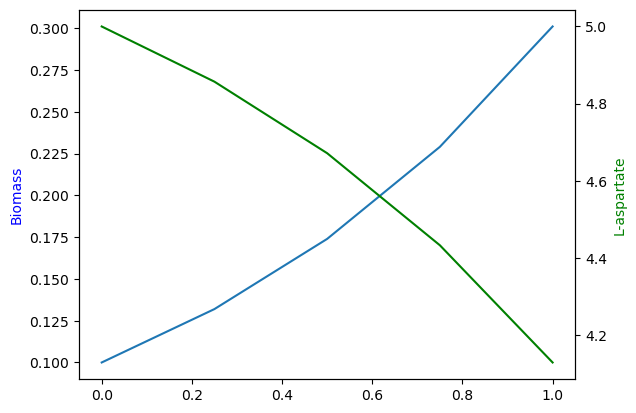

In [22]:
ax = plt.subplot(111)
ax.plot(sol.t, sol.y[0])
ax2 = plt.twinx(ax)
ax2.plot(sol.t, sol.y[1], color='g')

ax.set_ylabel('Biomass', color='b')
ax2.set_ylabel('L-aspartate', color='g')